In [ ]:
import random
import time
import numpy as np
import math
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torchvision.datasets import MNIST, CIFAR10

In [ ]:
!pip install functorch

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 21.4 MB 1.2 MB/s 


In [ ]:
from functorch import make_functional_with_buffers, vmap, grad
from functorch.experimental import replace_all_batch_norm_modules_

In [ ]:
torch.manual_seed(0);

In [ ]:
#@title Model {display-mode: "form"}

class MNIST_CNN(nn.Module):

    def __init__(self, input_shape, num_classes=10, hid_channels=64, out_channels=128):
        super(MNIST_CNN, self).__init__()
        # print(input_shape[0])
        self.conv1 = self.conv_block(input_shape, hid_channels//2)
        self.conv2 = self.conv_block(hid_channels//2, hid_channels)
        # self.conv3 = self.conv_block(hid_channels, hid_channels)
        self.conv4 = self.conv_block(hid_channels, out_channels)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(out_channels, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = self.conv4(x)
        x = self.avgpool(x)
        x = x.view(len(x), -1)
        x = self.fc(x)
        return x

    def conv_block(self, in_channels,  out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            # nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

In [ ]:
i = torch.randn(10,1,28,28)
model = MNIST_CNN(1, 10, 32, 64)
model

MNIST_CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc): Linear(in_features=64, out_features=10, bias=True)
)

In [ ]:
model(i).shape

torch.Size([10, 10])

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])
train_data = MNIST("./", transform=transform, download=True)
test_data = MNIST("./", False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
train_data.targets.shape, train_data.data.shape

(torch.Size([60000]), torch.Size([60000, 28, 28]))

In [ ]:
loader = DataLoader(train_data, 5)
test_loader = DataLoader(test_data, 5)

In [ ]:
images, labels = next(iter(loader))

In [ ]:
images.shape, labels.shape

(torch.Size([5, 1, 28, 28]), torch.Size([5]))

In [ ]:
outputs = model(images)

In [ ]:
fmodel, params, buffers = make_functional_with_buffers(model)
replace_all_batch_norm_modules_(fmodel)

FunctionalModuleWithBuffers(
  (stateless_model): MNIST_CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
fmodel

FunctionalModuleWithBuffers(
  (stateless_model): MNIST_CNN(
    (conv1): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
    (fc): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [ ]:
for x in params:
  print(f"{x.shape}")

print(f"\n{type(params)}")

torch.Size([16, 1, 3, 3])
torch.Size([32, 16, 3, 3])
torch.Size([64, 32, 3, 3])
torch.Size([10, 64])
torch.Size([10])

<class 'tuple'>


In [ ]:
def compute_loss_stateless_model (params, buffers, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)

    predictions = fmodel(params, buffers, batch) 
    loss = F.cross_entropy(predictions, targets)
    return loss

In [ ]:
ft_compute_grad = grad(compute_loss_stateless_model)

In [ ]:
ft_compute_sample_grad = vmap(ft_compute_grad, in_dims=(None, None, 0, 0))

In [ ]:
ft_per_sample_grads = ft_compute_sample_grad(params, buffers, images, labels)

In [ ]:
ft_per_sample_grads[-1]

tensor([[ 0.1056,  0.0858,  0.1179,  0.0983,  0.1033, -0.8913,  0.0891,  0.1095,
          0.0827,  0.0991],
        [-0.8952,  0.0883,  0.1169,  0.0967,  0.1045,  0.1096,  0.0879,  0.1086,
          0.0810,  0.1016],
        [ 0.1068,  0.0909,  0.1171,  0.0952, -0.8954,  0.1051,  0.0900,  0.1097,
          0.0811,  0.0995],
        [ 0.1079, -0.9089,  0.1190,  0.0959,  0.1049,  0.1048,  0.0902,  0.1059,
          0.0823,  0.0980],
        [ 0.1046,  0.0880,  0.1163,  0.0974,  0.1070,  0.1088,  0.0893,  0.1089,
          0.0802, -0.9004]], grad_fn=<ViewBackward0>)

In [ ]:
ft_per_sample_grads[-1].mean(axis=0)

tensor([-0.0941, -0.1112,  0.1175,  0.0967, -0.0952, -0.0926,  0.0893,  0.1085,
         0.0815, -0.1005], grad_fn=<MeanBackward1>)

In [ ]:
fc_grads[-1]

tensor([-0.0941, -0.1112,  0.1175,  0.0967, -0.0952, -0.0926,  0.0893,  0.1085,
         0.0815, -0.1005])

In [ ]:
g[-1]

DeviceArray([-0.0940784 , -0.11115795,  0.1174643 ,  0.09670475,
             -0.09516752, -0.09258518,  0.08929085,  0.10852768,
              0.08147626, -0.10047475], dtype=float32)

In [ ]:
loss = F.cross_entropy(outputs, labels)
loss.backward()

In [ ]:
model.fc.bias.grad

tensor([-0.0941, -0.1112,  0.1175,  0.0967, -0.0952, -0.0926,  0.0893,  0.1085,
         0.0815, -0.1005])

In [ ]:
next(iter(model.fc.parameters())).shape

torch.Size([10, 64])

In [ ]:
fc_grads = torch.autograd.grad(F.cross_entropy(outputs, labels), list(model.fc.parameters()))

In [ ]:
fc_grads = torch.autograd.grad(F.cross_entropy(outputs[0].unsqueeze(0), labels[0].unsqueeze(0)), list(model.fc.parameters()))

In [ ]:
fc_grads[1]

tensor([ 0.1174,  0.1142,  0.1033,  0.0905,  0.0827, -0.8808,  0.1026,  0.1052,
         0.0810,  0.0840])

In [ ]:
import jax
import jax.numpy as jnp

In [ ]:
x = images
for module in model.children():
    if not isinstance(module, nn.Linear):
        print(module)
        x = module(x)

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
Sequential(
  (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (1): ReLU()
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)
AdaptiveAvgPool2d(output_size=(1, 1))


In [ ]:
x = x.view(len(x), -1)
x.shape

torch.Size([5, 64])

In [ ]:
params = [model.fc.weight.detach().numpy(), model.fc.bias.detach().numpy()]

In [ ]:
F.linear(x, model.fc.weight, model.fc.bias).shape

torch.Size([5, 10])

In [ ]:
(jnp.dot(x.detach().numpy(), params[0].T) + params[1]).shape

(5, 10)

In [ ]:
def compute_crossentropyloss_manual(x,y0):
    """
    x is the vector with shape (batch_size,C)
    y0 shape is the same (batch_size), whose entries are integers from 0 to C-1
    """
    loss = 0.
    n_batch, n_class = x.shape
    # print(n_class)
    for x1,y1 in zip(x,y0):
        class_index = y1
        loss = loss + jnp.log(jnp.exp(x1[class_index])/(jnp.exp(x1).sum()))
    loss = - loss/n_batch
    return loss

In [ ]:
def loss(params, input, target):
    print(input.shape)
    out = jnp.dot(input, params[0].T) + params[1]
    print(out.shape)
    # out = F.linear(input, params[0], params[1])
    return compute_crossentropyloss_manual(out, target)

In [ ]:
# perex_grads = jax.jit(jax.vmap(jax.grad(loss), in_axes=(None, None, 1)))
perex_grads = jax.jit(jax.grad(loss))


In [ ]:
g = perex_grads(params, x.detach().numpy(), labels.numpy())
g

In [ ]:
g[1]

DeviceArray([-0.0940784 , -0.11115795,  0.1174643 ,  0.09670475,
             -0.09516752, -0.09258518,  0.08929085,  0.10852768,
              0.08147626, -0.10047475], dtype=float32)

# JAX

In [ ]:
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision.datasets import MNIST

In [ ]:
class MNIST_(MNIST):
    def __getitem__(self, index: int):
        image, label =  super().__getitem__(index)
        return image, label, index

In [ ]:
transform = Compose([ToTensor(), Normalize((0.1307,), (0.3081,))])
train_data = MNIST_("./", transform=transform, download=True)
test_data = MNIST_("./", False, transform=transform, download=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST_/raw/train-images-idx3-ubyte.gz to ./MNIST_/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST_/raw/train-labels-idx1-ubyte.gz to ./MNIST_/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST_/raw/t10k-images-idx3-ubyte.gz to ./MNIST_/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST_/raw/t10k-labels-idx1-ubyte.gz to ./MNIST_/raw



In [ ]:
train_images, train_labels, train_indices = next(iter(DataLoader(train_data, len(train_data), shuffle=True)))
train_images.shape, train_labels.shape

(torch.Size([60000, 1, 28, 28]), torch.Size([60000]))

In [ ]:
import numpy as np
import jax.numpy as jnp
import jax
from jax import grad, jit, vmap
from jax import random

In [ ]:
def one_hot(x, k, dtype=jnp.float32):
  """Create a one-hot encoding of x of size k."""
  return jnp.array(x[:, None] == jnp.arange(k), dtype)

In [ ]:
num_classes = 10
train_images = jnp.array(train_images).reshape(-1, 28*28)
train_labels = one_hot(jnp.array(train_labels), num_classes)
print("Train Images Shape", train_images.shape)
print("Train Labels Shape", train_labels.shape)

Train Images Shape (60000, 784)
Train Labels Shape (60000, 10)


In [ ]:
# A helper function to randomly initialize weights and biases
# for a dense neural network layer
def random_layer_params(m, n, key, scale=0.1):
    w_key, b_key = random.split(key)
    return scale * random.normal(w_key, (n, m)), scale * random.normal(b_key, (n,))

# Initialize all layers for a fully-connected neural network with sizes "sizes"
def init_network_params(sizes, key):
    keys = random.split(key, len(sizes))
    return [random_layer_params(m, n, k) for m, n, k in zip(sizes[:-1], sizes[1:], keys)]

layer_sizes = [784, 512, 128, 32, 10]
step_size = 0.01
num_epochs = 8
batch_size = 128
n_targets = 10
params = init_network_params(layer_sizes, random.PRNGKey(0))

In [ ]:
for x in params:
  print(f"Weight: {x[0].shape}\tBias: {x[1].shape}")

Weight: (512, 784)	Bias: (512,)
Weight: (128, 512)	Bias: (128,)
Weight: (32, 128)	Bias: (32,)
Weight: (10, 32)	Bias: (10,)


In [ ]:
from jax.scipy.special import logsumexp

def relu(x):
    return jnp.maximum(0, x)

def forward(params, x):
    # per-example predictions
    activations = x
    for w, b in params[:-1]:
        outputs = jnp.dot(w, activations) + b
        activations = relu(outputs)

    final_w, final_b = params[-1]
    logits = jnp.dot(final_w, activations) + final_b
    return logits - logsumexp(logits) # Basically log softmax

@grad
def loss(params, x, y):
    preds = forward(params, x)
    return -jnp.sum(preds * y)

In [ ]:
batched_loss = jit(vmap(loss, in_axes=(None, 0,0)))

In [ ]:
def iterate_minibatches(inputs, targets, batchsize):
    assert inputs.shape[0] == targets.shape[0]
    assert train_images.shape[0] % batchsize == 0
    for start_idx in range(0, inputs.shape[0] - batchsize + 1, batchsize):
        excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [ ]:
BatchSize = 1000
loader = iterate_minibatches(train_images, train_labels, batchsize=BatchSize)

In [ ]:
# gradient = batched_loss(params, train_images[:10], train_labels[:10])

In [ ]:
# type(gradient[0])

In [ ]:
cpus = jax.devices("cpu")
cpus

[CpuDevice(id=0)]

Too much memory Consumption

In [ ]:
gradients = [[None, None] for i in range(len(params))]
for i, batch in enumerate(loader):
    images, labels = batch
    gradient = batched_loss(params, images, labels)
    if gradients[0][0] is not None:
        for j in range(len(params)):
            gradients[j][0] = np.concatenate([gradients[j][0], np.asarray(gradient[j][0])])
            gradients[j][1] = np.concatenate([gradients[j][1], np.asarray(gradient[j][1])])
    else:
        for j in range(len(params)):
            gradients[j][0] = np.asarray(gradient[j][0])
            gradients[j][1] = np.asarray(gradient[j][1])
    break

In [ ]:
net_gradients = [[None, None] for i in range(len(params))]
for j in range(len(params)):
    net_gradients[j][0] = jnp.mean(gradients[j][0], axis=0)
    net_gradients[j][1] = jnp.mean(gradients[j][1], axis=0)

Finding Net Gradient first

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def get_net_gradeints(params, images, labels, batch_size):
    net_gradients = [[None, None] for i in range(len(params))]
    loader = iterate_minibatches(images, labels, batchsize=batch_size)
    for i, batch in tqdm(enumerate(loader), total = labels.shape[0]//batch_size, desc="Net Gradients", leave=False):
        images, labels = batch
        gradient = batched_loss(params, images, labels)
        if net_gradients[0][0] is not None:
            for j in range(len(params)):
                net_gradients[j][0] += gradient[j][0].sum(axis=0)
                net_gradients[j][1] += gradient[j][1].sum(axis=0)
        else:
            for j in range(len(params)):
                net_gradients[j][0] = gradient[j][0].sum(axis=0)
                net_gradients[j][1] = gradient[j][1].sum(axis=0)

    for j in range(len(params)):
        net_gradients[j][0] /= labels.shape[0]
        net_gradients[j][1] /= labels.shape[0]
    return net_gradients
# net_gradients = get_net_gradeints(params, train_images, train_labels, BatchSize)

Finding Similarity between gradients

In [ ]:
@jit
def cosinesimilarity(a,b):
    return jnp.divide(jnp.dot(a, b.T),  (jnp.linalg.norm(a) * jnp.linalg.norm(b)))

In [ ]:
cs = vmap(cosinesimilarity, in_axes=(0, None))

In [ ]:
def get_similarities(params, images, labels, batch_size, net_gradients):
    loader = iterate_minibatches(images, labels, batchsize=batch_size)
    similarities = []
    progress_bar = tqdm(enumerate(loader), total = labels.shape[0]//batch_size, desc="Per Sample Gradient Similarity", leave=False)
    for i, batch in progress_bar:
        imgs, label = batch
        gradient = batched_loss(params, imgs, label)
        sim=0
        for j in range(len(params)):
            sim += cs(gradient[j][0].reshape(batch_size,-1), net_gradients[j][0].reshape(1,-1))
        similarities.append(sim)
    return jnp.concatenate(similarities)
# similarities = get_similarities(params, train_images, train_labels, BatchSize, net_gradients)

In [ ]:
similarities = jnp.concatenate(similarities)
similarities.shape

(60000, 1)

In [ ]:
topn = 500
inds = np.argpartition(-np.asarray(similarities).squeeze(), 500)[:500]


In [ ]:
iterations = 100
topn = 500
BatchSize = 1500
good_inds = []
for k in tqdm(range(iterations), desc="Iterations"):
    params = init_network_params(layer_sizes, random.PRNGKey(k))
    net_gradients = get_net_gradeints(params, train_images, train_labels, BatchSize)
    similarities = get_similarities(params, train_images, train_labels, BatchSize, net_gradients)
    
    inds = np.argpartition(-np.asarray(similarities).squeeze(), 500)[:500]
    good_inds.append(inds)

good_inds = np.concatenate(good_inds)

In [ ]:
good_inds = np.concatenate(good_inds)
good_inds.shape

(182000,)

In [ ]:
values, counts = np.unique(good_inds, return_counts=True)
# ref:https://stackoverflow.com/a/28736715/13730689

In [ ]:
counts.max()

75

In [ ]:
inds = np.argpartition(-counts, kth=500)[:500]

In [ ]:
counts[inds]

In [ ]:
best_inds = values[inds]

In [ ]:
best_inds.shape

(500,)

In [ ]:
train_indices[best_inds]

tensor([19543, 29299, 10914, 10606, 36723, 35038, 24429,  4488, 29319, 41170,
         1333,  8527,  4201, 27951, 12057, 28451, 48121, 20060, 10233, 26139,
         2598, 36627, 16119, 42623, 25497, 28365, 37153, 33670, 53028, 59457,
        20911,  1927,  1237, 11035, 28585, 29279, 42776,  8545, 33003, 23940,
        32293, 36241,  8369, 42575, 39071,  6369, 33719, 47073, 35700, 10140,
         1371, 44979, 12009, 20215, 22693, 10245,  6103, 13065, 39581, 16114,
        30668, 15890, 19490,  6768, 36677, 28101,  7981, 46166, 50745, 19485,
         4854, 19223, 39489, 33933, 29469, 45798,  1179,  5475, 27050, 52409,
        19291, 33664, 58457,  6017,   427,  7985, 59420,  1269, 22344, 53400,
        28607, 36569, 48167, 38231,  5488, 10229, 23562, 39115, 10203, 15458,
        23293,  8809, 19859, 39615,  1247, 37183, 50873, 36605,  4123, 37083,
         1969, 39503,  1267, 36414,  5977,  2005, 21785, 20979, 29306, 35400,
        14179, 10221, 52832, 48059, 19565, 19871, 18253, 38155, 

In [ ]:
train_data.targets[train_indices[best_inds]]

tensor([0, 8, 0, 3, 3, 8, 0, 0, 8, 6, 9, 0, 0, 0, 0, 0, 0, 0, 8, 0, 8, 8, 0, 0,
        0, 0, 0, 0, 8, 0, 0, 0, 8, 8, 6, 8, 0, 0, 0, 0, 0, 0, 0, 8, 8, 8, 8, 0,
        0, 0, 0, 0, 8, 0, 6, 0, 0, 8, 0, 8, 0, 0, 0, 0, 8, 0, 0, 0, 8, 0, 0, 8,
        3, 0, 0, 8, 0, 0, 0, 0, 8, 8, 0, 8, 0, 0, 0, 6, 0, 8, 0, 0, 0, 0, 0, 6,
        8, 0, 0, 8, 0, 0, 0, 0, 8, 0, 8, 8, 0, 2, 0, 0, 8, 0, 8, 6, 8, 0, 8, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 8, 0, 0, 8, 8, 0, 0, 8, 8, 0, 8,
        8, 0, 0, 0, 8, 0, 8, 0, 8, 0, 0, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 8, 0, 0, 0, 0, 8, 0, 0, 8, 8, 8, 8, 0, 0, 0, 8, 2, 6, 8, 0, 8, 0, 0,
        0, 8, 8, 0, 8, 0, 8, 0, 8, 0, 0, 0, 3, 8, 3, 0, 8, 8, 8, 0, 8, 0, 0, 0,
        0, 8, 8, 8, 0, 0, 8, 0, 8, 8, 3, 0, 8, 2, 0, 3, 8, 8, 0, 0, 8, 0, 0, 0,
        0, 0, 0, 6, 8, 8, 6, 0, 0, 8, 8, 6, 0, 8, 0, 3, 0, 2, 0, 6, 9, 8, 8, 8,
        0, 0, 8, 3, 8, 0, 0, 8, 0, 3, 8, 6, 0, 3, 9, 0, 8, 0, 2, 8, 0, 8, 8, 9,
        8, 8, 0, 8, 0, 8, 8, 0, 6, 8, 2,

In [ ]:
np.save("best_inds_364",[train_indices.n umpy()[best_inds]])

# Training


In [ ]:
from torch.utils.data import Subset, DataLoader
import torch.nn as nn
from torch.optim import SGD

In [ ]:
data = Subset(train_data, best_inds)
data.__len__()

500

In [ ]:
images, labels = next(iter(DataLoader(data, len(data), shuffle=True)))
images.shape, labels.shape

(torch.Size([500, 1, 28, 28]), torch.Size([500]))

In [ ]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt


In [ ]:
img_grid = make_grid(images, 10, pad_value=1, normalize=True)

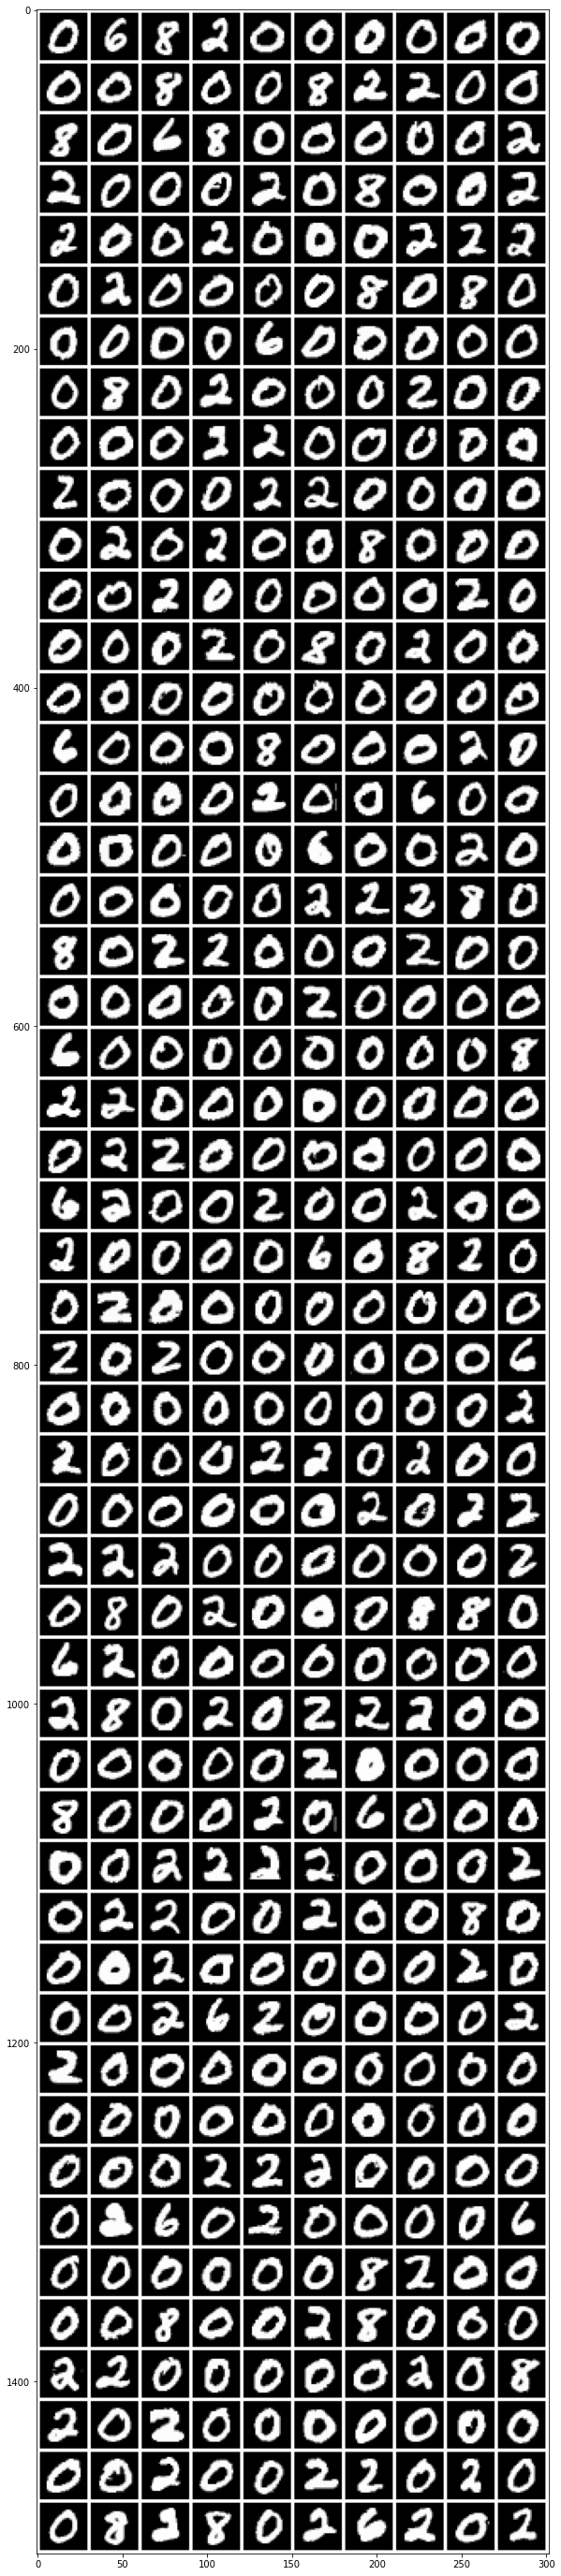

In [ ]:
plt.figure(figsize=(10, 50))
plt.imshow(img_grid.permute(1,2,0))

In [ ]:
images = images.reshape(len(data), -1).cuda()
labels = labels.cuda()
images.shape

torch.Size([500, 784])

In [ ]:
test_loader = DataLoader(test_data, 1000, num_workers=2, pin_memory=True)

In [ ]:
layers = []
for i in range(len(layer_sizes)-1):
    layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
    layers.append(nn.ReLU())
layers[-1] = nn.LogSoftmax(1)

In [ ]:
model = nn.Sequential(*layers)
model.cuda()

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [ ]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.normal_(m.weight)
        nn.init.normal_(m.bias)
        m.weight.data.multiply_(0.1)
        m.bias.data.multiply_(0.1)
model.apply(init_weights)

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [ ]:
from torch import inference_mode

In [ ]:
@inference_mode()
def test(loader, model):
    correct = 0
    for (images, labels) in loader:
        images, labels = images.cuda(), labels.cuda()
        output = model(images)
        acc = output.argmax(dim=1).eq(labels).sum().item()
        correct += acc
    return correct

In [ ]:
optimizer = SGD(model.parameters(), lr=0.1)
criterion = nn.NLLLoss()

In [ ]:
Epochs = 1000

In [ ]:
from tqdm import trange

In [ ]:
losses = []
for epoch in trange(Epochs):
    optimizer.zero_grad(set_to_none=True)
    output = model(images)
    loss = criterion(output, labels)
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    if epoch % 50 == 0:
        acc = output.argmax(dim=1).eq(labels).mean().item()
        print(f"Epoch[{epoch+1}] Loss: {loss.item():.2f}\tAccuracy: {acc}")
        correct = test(test_loader, model)
        print(f'Test Accuracy: {correct / len(test_data)}')

# Trial and Error
nothing to see here

In [ ]:
@jit
def cs_(a,b):
    return jnp.divide(jnp.dot(a, b.T),  (jnp.linalg.norm(a) * jnp.linalg.norm(b)))

In [ ]:
cs = vmap(cs_, in_axes=(0, None))

In [ ]:
cos_s = cs(gradients[0][0].reshape(1000,-1), net_gradients[0][0].reshape(1,-1))
# cos_s

In [ ]:
cos_s.shape

(1000, 1)

In [ ]:
sim3 = None
for j in range(len(params)):
    if sim3 is not None:
        sim3 += cs(gradients[j][0].reshape(1000,-1), net_gradients[j][0].reshape(1,-1))
    else:
        sim3 = cs(gradients[j][0].reshape(1000,-1), net_gradients[j][0].reshape(1,-1))

In [ ]:
sim

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
cos_sim = cosine_similarity(gradients[0][0].reshape(1000,-1), net_gradients[0][0].reshape(1,-1))

In [ ]:
cos_sim

In [ ]:
sim2 = 0
for j in range(len(params)):
    sim2 += cosine_similarity(gradients[j][0].reshape(1000,-1), net_gradients[j][0].reshape(1,-1))

In [ ]:
sim2

In [ ]:
np.allclose(cos_s, cos_sim)

True

In [ ]:
sim3.shape

(1000, 1)

In [ ]:
np.all(sim == sim3)

DeviceArray(True, dtype=bool)

In [ ]:
cos_s.min()

DeviceArray(-0.15178497, dtype=float32)

In [ ]:
a = np.argpartition(-np.asarray(similarities).squeeze(), 500)[:500]


In [ ]:
b = np.argpartition(np.asarray(similarities).squeeze(), -500)[-500:]
# ref: https://stackoverflow.com/questions/6910641/how-do-i-get-indices-of-n-maximum-values-in-a-numpy-array

In [ ]:
a.sort()

In [ ]:
b.sort()

In [ ]:
np.all(a==b)

True

## Jax to Pytorch

In [ ]:
num_classes = 10
train_images = train_data.data.reshape(-1, 28*28) / 255
train_labels = train_data.targets
print("Train Images Shape", train_images.shape)
print("Train Labels Shape", train_labels.shape)

Train Images Shape torch.Size([60000, 784])
Train Labels Shape torch.Size([60000])


In [ ]:
layers = []
for i in range(len(layer_sizes)-1):
    layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
    layers.append(nn.ReLU())
layers[-1] = nn.LogSoftmax(1)

In [ ]:
temp_model = nn.Sequential(*layers)
temp_model

Sequential(
  (0): Linear(in_features=784, out_features=512, bias=True)
  (1): ReLU()
  (2): Linear(in_features=512, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=10, bias=True)
  (7): LogSoftmax(dim=1)
)

In [ ]:
i = 0
for module in temp_model.children():
    if isinstance(module, nn.Linear):
        print(i,module)
        module.weight = nn.Parameter(torch.tensor(np.asarray(params[i][0])))
        module.bias = nn.Parameter(torch.tensor(np.asarray(params[i][1])))
        i += 1

0 Linear(in_features=784, out_features=512, bias=True)
1 Linear(in_features=512, out_features=128, bias=True)
2 Linear(in_features=128, out_features=32, bias=True)
3 Linear(in_features=32, out_features=10, bias=True)


In [ ]:
temp_model=temp_model.cuda()

In [ ]:
criterion = nn.NLLLoss().cuda()

In [ ]:
# from functorch import make_functional_with_buffers, vmap, grad
# from functorch.experimental import replace_all_batch_norm_modules_
import functorch

In [ ]:
fmodel, params, buffers = functorch.make_functional_with_buffers(temp_model)

In [ ]:
fmodel

FunctionalModuleWithBuffers(
  (stateless_model): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=10, bias=True)
    (7): LogSoftmax(dim=1)
  )
)

In [ ]:
for x in params:
  print(f"{x.shape}")

print(f"\n{type(params)}")

torch.Size([512, 784])
torch.Size([512])
torch.Size([128, 512])
torch.Size([128])
torch.Size([32, 128])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])

<class 'tuple'>


In [ ]:
@functorch.grad
def compute_loss_stateless_model (params, buffers, sample, target):
    batch = sample.unsqueeze(0)
    targets = target.unsqueeze(0)

    predictions = fmodel(params, buffers, batch) 
    loss = criterion(predictions, targets)
    return loss

In [ ]:
ft_compute_grad = functorch.grad(compute_loss_stateless_model)

In [ ]:
# ft_compute_sample_grad = functorch.vmap(ft_compute_grad, in_dims=(None, None, 0, 0))
ft_compute_sample_grad = functorch.vmap(compute_loss_stateless_model, in_dims=(None, None, 0, 0))

In [ ]:
ft_per_sample_grads = ft_compute_sample_grad(
                                params, 
                                buffers, 
                                train_images[:10].cuda(), 
                                train_labels[:10].cuda()
                            )

In [ ]:
ft_per_sample_grads[0]

In [ ]:
np.allclose(np.asarray(l[1][0]), np.asarray(ft_per_sample_grads[2].cpu().detach()))

True

In [ ]:
%timeit ft_compute_sample_grad(params, buffers, train_images[:10].cuda(), train_labels[:10].cuda())

100 loops, best of 5: 2.56 ms per loop
